# Analyze Data Online: Predicting Credit Risk with R

## Feature Engineering & Decision Trees using R

The objective of this notebook series is to simulate an analytical workflow between several team members using [Python](https://www.python.org/), [R](http://www.r-project.org/), and [Excel](https://products.office.com/en-us/excel). The data for this notebook is part of a [Kaggle competition](https://www.kaggle.com/c/GiveMeSomeCredit) released three years ago. The objective is to predict the probability of credit & loan default from a large set of real customer data. The evaluate metric used in the competition was [AUC](https://www.kaggle.com/wiki/AreaUnderCurve). A perfect model will score an AUC of 1, while random guessing will score an AUC of around 0.5, a meager 50% chance. 

> This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years. The goal of this competition is to build a model that borrowers can use to help make the best financial decisions. Historical data are provided on 250,000 borrowers and the prize pool is $5,000.

The top score for the competition was 0.869558, which we will try to match! However, it will be challenging since some of the data from the competition is no longer available.

[Plotly](https://plot.ly) is a platform for making interactive graphs with R, Python, MATLAB, and Excel. In this notebook series, [Plotly](https://plot.ly) can serve as a sharing platform for data, visualizations, and results between analysts, management, and executives on Plotly’s free public cloud. For collaboration and sensitive data, you can run Plotly [on your own servers](https://plot.ly/product/enterprise/ ).

Need help converting [Plotly](https://plot.ly) graphs from R or Python?
- [R](https://plot.ly/r/user-guide/)
- [Python](https://plot.ly/python/matplotlib-to-plotly-tutorial/)


**This is the first notebook in the series**


- The [first notebook] explores, cleans, and generates new features for the data.
- The [second notebook] tests and optimizes the [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model using [Plotly](https://plot.ly) and Python.
<hr>



For this code to run on your machine, you will need to:

- Install some R Packages: Running `install.packages("<library_name>")` in your R console will install R packages.

- Register an account with [Plotly](https://plot.ly/feed/) to receive your API key. 

- Download the data for this notebook on the [kaggle website](https://www.kaggle.com/c/GiveMeSomeCredit).

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>
<script src="https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js"></script>

# Initiating the analysis with R

**Exploring**

First we will summarize and plot the data. This step will help us better understand the data, as well as identify its potential flaws. For example, the data could be missing values, or have observations which don't make sense, e.g. age = 0.

**Cleaning**

With any real dataset, data cleaning is the one of the trickiest pieces of an analysis. We see that two variables, `MonthlyIncome` and `NumberOfDependents` have missing values. `Age` also has a few observations of zero, which were probably miscoded.  The machine learning algorithms we will use in these notebooks are insensitive to missing values and outliers in the data, therefore, instead of interpolation we will simply create new dummy variables for missing values. 

**Feature Engineering**

A 'feature' is simply machine-learning jargon for a variable / column in our dataset.

With only 10 features, it will probably be beneficial to create a few new features of our own. For example: by combining features with `Number of Open Credit Lines and Loans`,  we can engineer new features such as:
    
   - Number of open credit lines per dependent
   - Number of major delinquencies per open credit line 
   - Does the customer have at least 1 open credit line or loan?
   
Creating new features is something most tutorials overlook. However, carefully engineering new features can lead to strong improvements in a model's predictive power.

## Load libraries and data

In [73]:
library(dplyr)
library(plotly)
library(knitr)
library(IRdisplay)

options(scipen=999)

In [74]:
# Load in the data into memory
dt <- read.csv('https://raw.githubusercontent.com/plotly/datasets/master/data.csv', stringsAsFactors = F)

# Create new dataframe that stores temporary exploratory variables
tmp <- data.frame(Y = dt$SeriousDlqin2yrs)

You can download the data for this notebook on the [kaggle website](https://www.kaggle.com/c/GiveMeSomeCredit).

## Examine the data structure

Let's take a look at the data structure. We see there are 15,000 observations and 10 independent variables. To see the description of each variable, it will be easier if we load in the data dictionary provided on kaggle.

In [75]:
str(dt)

'data.frame':	150000 obs. of  11 variables:
 $ SeriousDlqin2yrs                    : int  1 0 0 0 0 0 0 0 0 0 ...
 $ RevolvingUtilizationOfUnsecuredLines: num  0.766 0.957 0.658 0.234 0.907 ...
 $ age                                 : int  45 40 38 30 49 74 57 39 27 57 ...
 $ NumberOfTime30.59DaysPastDueNotWorse: int  2 0 1 0 1 0 0 0 0 0 ...
 $ DebtRatio                           : num  0.803 0.1219 0.0851 0.036 0.0249 ...
 $ MonthlyIncome                       : int  9120 2600 3042 3300 63588 3500 NA 3500 NA 23684 ...
 $ NumberOfOpenCreditLinesAndLoans     : int  13 4 2 5 7 3 8 8 2 9 ...
 $ NumberOfTimes90DaysLate             : int  0 0 1 0 0 0 0 0 0 0 ...
 $ NumberRealEstateLoansOrLines        : int  6 0 0 0 1 1 3 0 0 4 ...
 $ NumberOfTime60.89DaysPastDueNotWorse: int  0 0 0 0 0 0 0 0 0 0 ...
 $ NumberOfDependents                  : int  2 1 0 0 0 1 0 0 NA 2 ...


In [76]:
data_dict <- read.csv('https://github.com/plotly/datasets/raw/master/data_dictionary.csv', stringsAsFactors = F)

data_dict[, 1:2]

,Variable.Name,Description
1,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse
2,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
3,age,Age of borrower in years
4,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
5,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income"
6,MonthlyIncome,Monthly income
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit
10,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.


## Descriptive Summarizing

In [77]:
# We could use R's built-in `summary` function. But this function provides cleaner output within a notebook
t(sapply(dt, function(x) {
   list(
        mean = mean(x, na.rm = T),
        sd  = sd(x, na.rm = T),
        min = quantile(x, na.rm = T)[1],
        q25 = quantile(x, na.rm = T)[2],
        q50 = quantile(x, na.rm = T)[3],
        q75 = quantile(x, na.rm = T)[4],
        max = quantile(x, na.rm = T)[5],
        num_NA = sum(is.na(x))
   )
    }))

,mean,sd,min,q25,q50,q75,max,num_NA
SeriousDlqin2yrs,0.06684,0.2497455,0,0,0,0,1,0
RevolvingUtilizationOfUnsecuredLines,6.048438,249.7554,0,0.02986744,0.1541807,0.5590462,50708,0
age,52.29521,14.77187,0,41,52,63,109,0
NumberOfTime30.59DaysPastDueNotWorse,0.4210333,4.192781,0,0,0,0,98,0
DebtRatio,353.0051,2037.819,0,0.1750738,0.3665078,0.8682538,329664,0
MonthlyIncome,6670.221,14384.67,0,3400,5400,8249,3008750,29731
NumberOfOpenCreditLinesAndLoans,8.45276,5.145951,0,5,8,11,58,0
NumberOfTimes90DaysLate,0.2659733,4.169304,0,0,0,0,98,0
NumberRealEstateLoansOrLines,1.01824,1.129771,0,0,1,2,54,0
NumberOfTime60.89DaysPastDueNotWorse,0.2403867,4.155179,0,0,0,0,98,0


## Plotting with Plotly in Jupyter

We are using the Plotly [ggplot2 converter](https://plot.ly/ggplot2/) to turn ggplot2 plots into interactive graphs drawn with D3.js. This is a perfect way to make ggplot's more engaging and easy to share inside or outside of [Rstudio](https://www.rstudio.com).

To embed a plot we simply call the function `ggplotly()` on our API connection object (`py`, defined below). We can then specify the `session` argument, which will allow us to embed our graph into either:

- Rstudio R Markdown documents using `session = 'knitr'`
- IPython / Jupyter notebooks using `session = 'notebook'`

You can sign up for your own free API key [here](https://plot.ly/api/).

In [78]:
# Authenticate to plotly's api using your account
py <- plotly("rmdk", "0sn825k4r8")

# Going through each feature...

## Age

First let's create a simple ggplot.

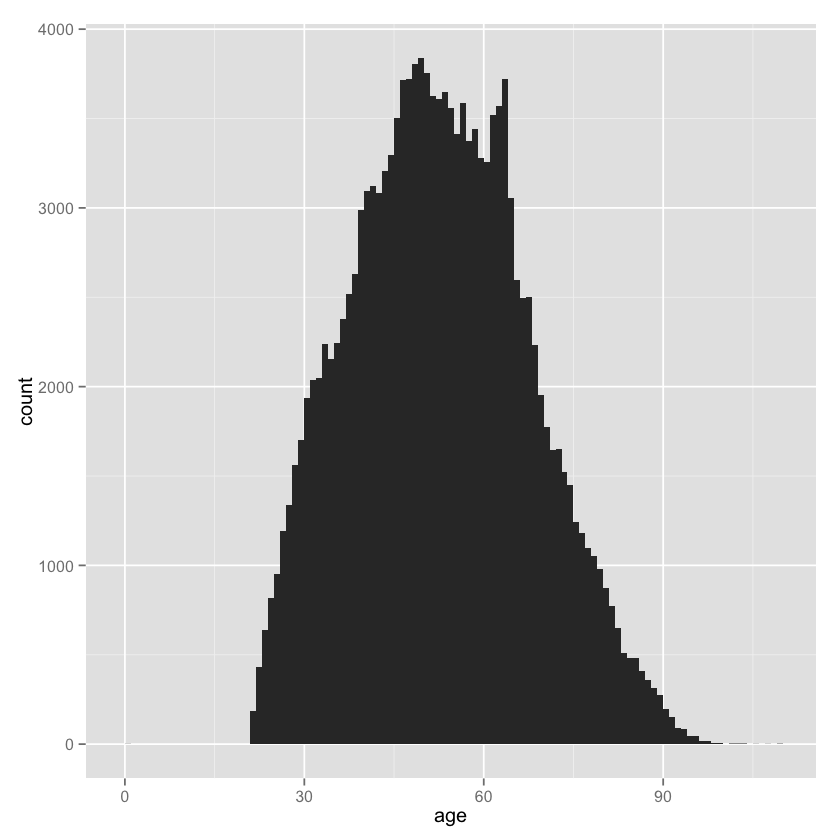

In [79]:
# Create the plot with ggplot2
plt_age <- ggplot(dt, aes(age)) + geom_histogram(binwidth = 1)

plt_age

Now let's convert it! [Plotly](https://plot.ly) graphs are fully interactive. You can hover your mouse to see data or click and drag to zoom. 

In [80]:
# Plot the graph within the notebook
py$ggplotly(plt_age, session = 'notebook')

We can easily plot many different types of graphs with Plotly. An interactive box plot makes it easy to see the values of the quantiles and outliers.

In [81]:
# Create the plot with ggplot2
plt_age <- ggplot(dt, aes(x = as.factor(SeriousDlqin2yrs), y = age)) + geom_boxplot() + xlab('Defaulted on Loan')

# Plot the graph within the notebook
py$ggplotly(plt_age, session = 'notebook')

Let's examine `age` by our dependent variable. We will have to cut the data into reasonable groups, and plot the likelihood of defaulting within each group.

In [82]:
# Cut DebtRatio into meaningful factors
tmp$age <- cut(dt$age, breaks = c(0, 18, 25, 35, 45, 55, 65, 75, 1e6), 
                       labels = c("0", "0-18", "18-25", "25-35", "35-45", "45-55", "55-65", "65-75"), 
                       ordered.result = T)

In [83]:
# Function used to prepare the data
bin_ <- function(x) {
    tmp %>% 
    group_by_(x, 'Y') %>% summarise(N = n()) %>% 
        group_by_(x)  %>% mutate(T = sum(N)) %>%
        ungroup() %>%
        mutate(Probability.of.Default = round(N / T * 100, 2)) %>% filter(Y == 1)
}

Finally, we can plot the result. As expected, we have a fairly linear trend where the probability of defaulting decreases with `age`.

In [84]:
age_bins <- ggplot(bin_('age'), aes(age, Probability.of.Default)) + geom_bar(stat = 'identity')

py$ggplotly(age_bins, session = 'notebook')

For simplicity, and since `age` is fairly normally distributed, we will simply assign any `0` ages to the median value of `age`.

In [85]:
median_age <- median(dt$age) 

dt$age[dt$age == 0] <- median_age

In [86]:
# Log transformation
dt$log_age <- log(dt$age)
dt$log_age[dt$low_age == 1] <- 0

## Monthly Income

We can see that this data is radically right-skewed, but we have no concrete reason to dispute these values are incorrect.

In [87]:
quantile(dt$MonthlyIncome, na.rm = T)

0%     25%     50%     75%    100% 
      0    3400    5400    8249 3008750

Let's examine the likelihood of default against monthly income.

In [88]:
# Cut DebtRatio into meaningful factors
tmp$MonthlyIncome <- cut(dt$MonthlyIncome, c(0, 1, 100, 5000, 1e4, 1.5e4, 1e8), 
                       c("0", "2-100", "100-5,000", "5,000-10,000", "10,000-15,000", "15,000+"), 
                         ordered.result = T, include.lowest = T)

In [89]:
income_bins <- ggplot(bin_('MonthlyIncome'), aes(MonthlyIncome, Probability.of.Default)) + geom_bar(stat = 'identity')

py$ggplotly(income_bins, session = 'notebook')

**Data Concerns:**


1. There are many values in unexpectedly low monthly income levels. Further, these low income levels also have the lowest likelihood of default, which does not intuitively make sense. 

2. There are missing values.

<hr>

It is not clear why there are so many very low income (< $100) observations. A logical guess may be this data came from a web-form and was user-populated, and some users preferred not to disclose their income. The 605 users with `$1` of income a month is troubling, perhaps those users meant `$1000`. 

> Ideally, we would test a few different hypotheses and examine the result of the model. 

For this notebook we will assume:

- Values of 0 make no income
- Values between 1--100 input their salaries in thousands.
- Income divisible by 100, 1000, and 5000 may be useful features.

In [90]:
# Unknown Income
dt$UnknownIncome <- as.integer(is.na(dt$MonthlyIncome))
dt$MonthlyIncome[dt$UnknownIncome == 1] <- 0  # set NA's to 0

# No income
dt$NoIncome <- as.integer(dt$MonthlyIncome == 0)
dt$NoIncome[is.na(dt$NoIncome)] <- 0

# Income < 100 * 1000
dt$MonthlyIncome[dt$MonthlyIncome %in% 1:100] <- dt$MonthlyIncome[dt$MonthlyIncome %in% 1:100] * 1000

# Income divisibe by ~1000's
dt$Income_100 <- as.integer(dt$MonthlyIncome %% 100 == 0)
dt$Income_1000 <- as.integer(dt$MonthlyIncome %% 1000 == 0)
dt$Income_5000 <- as.integer(dt$MonthlyIncome %% 5000 == 0)

# Log transformation
dt$log_income <- log(dt$MonthlyIncome)
dt$log_income[!is.finite(dt$log_income) | is.na(dt$log_income)] <- 0

# Income per person and by age
dt$log_income_person <- dt$log_income - log1p(dt$NumberOfDependents)
dt$log_income_person[is.na(dt$log_income_person)] <- 0
dt$log_income_age <- dt$log_income - log1p(dt$age)

## Debt Ratio

While we expect `Debt Ratio` to reside between 0 and 1, there are customers whose total assets are far less than total debits.

In [91]:
quantile(dt$DebtRatio)

0%            25%            50%            75%           100% 
     0.0000000      0.1750738      0.3665078      0.8682538 329664.0000000

In [92]:
# Cut DebtRatio into meaningful factors
tmp$DebtRatio <- cut(dt$DebtRatio, c(0, 0.25, 0.5, 0.75, 1, 2, 1e6), 
                       c("0 - .25", ".25 - .50", ".50 - .75", ".75 - 1", "1 - 2", "2+"), 
                       ordered.result = T, include.lowest = T)

In [93]:
debt_bins <- ggplot(bin_('DebtRatio'), aes(x = DebtRatio, y = Probability.of.Default)) + geom_bar(stat = 'identity')

py$ggplotly(debt_bins, session = 'notebook')

We can clearly see that the likelihood of our customers defaulting increases with Debt Ratio. The highest likelihood exists between 1--2, where expenses are slightly higher than assets.

We will create a few new dummy variables to deal with the 0's and missing data in `DebtRatio`. `DebtRatio` is automatically computed as a function of income, therefore we have to correct for when DebtRatio == 0 and recompute DebtRatio where we have made changes to `MonthlyIncome`.

In [94]:
# Has zero debt ratio
dt$ZeroDebtRatio <- as.integer(dt$DebtRatio == 0)

# Where income is unknown, set DebtRatio to 0
dt$UnknownIncomeDebtRatio <- dt$DebtRatio
dt$UnknownIncomeDebtRatio[dt$UnknownIncome == 0] <- 0
dt$DebtRatio[dt$UnknownIncome == 1] <- 0

# Recompute Debt Ratio where MonthlyIncome was 1:100
dt$log_Debt <- log(pmax(dt$MonthlyIncome, rep(1, nrow(dt))) * dt$DebtRatio)
dt$log_Debt[!is.finite(dt$log_Debt)] <- 0

# DebtRatio over x
dt$DTIOver33 <- as.integer(dt$NoIncome == 0 & dt$DebtRatio > 0.33)
dt$DTIOver43 <- as.integer(dt$NoIncome == 0 & dt$DebtRatio > 0.43)

# Log transformation
dt$log_DebtRatio <- log(dt$DebtRatio)
dt$log_DebtRatio[!is.finite(dt$log_DebtRatio)] <- 0

## Number Of Dependents 

We see that most customers have 1 or less dependents. We expect that as the number of dependents increases, so will the probability of defaulting.

In [95]:
quantile(dt$NumberOfDependents, probs = c(0, .50, .75, .90, .95, 1), na.rm = T)

0%  50%  75%  90%  95% 100% 
   0    0    1    2    3   20

In [96]:
tmp$NumberOfDependents <- cut(dt$NumberOfDependents, c(0, 1, 2, 3, 4, 5, 1e4), c("0", "1", "2", "3", "4", "5+"), 
                                ordered.result = T, include.lowest = T)

In [97]:
dependents_bins <- ggplot(bin_('NumberOfDependents'), aes(NumberOfDependents, Probability.of.Default)) + 
                            geom_bar(stat = 'identity')

py$ggplotly(dependents_bins, session = 'notebook')

As expected, the probably of default increases with the number of dependents. Let's create a few extra dummy variables that we suspect may be useful in our model.

In [98]:
# Unknown dependents
dt$UnknownNumberOfDependents <- as.integer(is.na(dt$NumberOfDependents))

# No dependents
dt$NoDependents <- as.integer(dt$NumberOfDependents == 0)
dt$NoDependents[is.na(dt$NoDependents)] <- 0

# When dependents NA assign 0
dt$NumberOfDependents[dt$UnknownNumberOfDependents == 1] <- 0 

# Has dependents
dt$Has.Dependents <- as.integer(dt$NumberOfDependents > 0)

# Log transformation
dt$log_HouseholdSize <- log1p(dt$NumberOfDependents)

## Number Of Times 90 Days Late

We expect this feature to be very useful in predicting customer defaults. Repeated late payments suggest that the customer is having difficulty paying off loans and other expenses.

In [99]:
quantile(dt$NumberOfTimes90DaysLate, probs = c(0, .75, .9, .95, .99, 1))

0%  75%  90%  95%  99% 100% 
   0    0    0    1    3   98

In [100]:
tmp$Times90DaysLate <- cut(dt$NumberOfTimes90DaysLate, c(0, 1, 2, 3,100), c('0', '1', '2','3-100'),
                            ordered.result = T, include.lowest = T)

In [101]:
times_90_days_late <- ggplot(bin_('Times90DaysLate'), aes(Times90DaysLate, Probability.of.Default)) + 
                        geom_bar(stat = 'identity')

py$ggplotly(times_90_days_late, session = 'notebook')

Surprisingly, even a single late payment increases the probability of default by ~45%. From 1 late payment on, the probability of default increases fairly linearly. You might have expected too see the difference between 1 and 2 late payments to be more significant, since it may account for an accidentally missed payment.

In [102]:
table(dt$NumberOfTimes90DaysLate)


     0      1      2      3      4      5      6      7      8      9     10 
141662   5243   1555    667    291    131     80     38     21     19      8 
    11     12     13     14     15     17     96     98 
     5      2      4      2      2      1      5    264 

It appears the true maximum for number of days late is 17. Values of 98 & 96 probably represent some type of code. We will create new features to reflect this assumption.

In [103]:
# Many days late
dt$NumberOfTimes90DaysLateLarge <- as.integer(dt$NumberOfTimes90DaysLate > 90)

# Specific codes as new dummy variables
dt$NumberOfTimes90DaysLate96 <- as.integer(dt$NumberOfTimes90DaysLate == 96)
dt$NumberOfTimes90DaysLate98 <- as.integer(dt$NumberOfTimes90DaysLate == 98)

# Never late
dt$Never90DaysLate <- as.integer(dt$NumberOfTimes90DaysLate == 0)

# Remove values > 90
dt$NumberOfTimes90DaysLate[dt$NumberOfTimes90DaysLate > 90] <- 0

# Log transformation
dt$log_NumberOfTimes90DaysLate <- log(dt$NumberOfTimes90DaysLate)
dt$log_NumberOfTimes90DaysLate[!is.finite(dt$log_NumberOfTimes90DaysLate)] <- 0

## Number Of Times 60 - 89 Days Late

The data for this feature are expectantly very similar to the 90 days late feature.

In [104]:
quantile(dt$NumberOfTime60.89DaysPastDueNotWorse, probs = c(0, .75, .9, .95, .99, 1))

0%  75%  90%  95%  99% 100% 
   0    0    0    1    2   98

In [105]:
tmp$Times60_89DaysLate <- cut(dt$NumberOfTime60.89DaysPastDueNotWorse, c(0, 1, 2, 3,100), c('0', '1', '2','3-100'),
                                  ordered.result = T, include.lowest = T)

In [106]:
times_60_89_days_late <- ggplot(bin_('Times60_89DaysLate'), aes(Times60_89DaysLate, Probability.of.Default)) + 
                                geom_bar(stat = 'identity')

py$ggplotly(times_60_89_days_late, session = 'notebook')

The trend is no different compared to the 90 days late feature. We will apply the same feature engineering techniques above.

In [107]:
# Was late many times
dt$NumberOfTime60.89DaysPastDueNotWorseLarge <- as.integer(dt$NumberOfTime60.89DaysPastDueNotWorse > 90)

# Potential coded values
dt$NumberOfTime60.89DaysPastDueNotWorse96 <- as.integer(dt$NumberOfTime60.89DaysPastDueNotWorse == 96)
dt$NumberOfTime60.89DaysPastDueNotWorse98 <- as.integer(dt$NumberOfTime60.89DaysPastDueNotWorse == 98)

# Was never late
dt$Never60.89DaysPastDueNotWorse <- as.integer(dt$NumberOfTime60.89DaysPastDueNotWorse == 0)

# Remove values above 90
dt$NumberOfTime60.89DaysPastDueNotWorse[dt$NumberOfTime60.89DaysPastDueNotWorse > 90] <- 0

# Log transformation
dt$log_NumberOfTime60.89DaysPastDueNotWorse <- log(dt$NumberOfTime60.89DaysPastDueNotWorse)
dt$log_NumberOfTime60.89DaysPastDueNotWorse[!is.finite(dt$log_NumberOfTime60.89DaysPastDueNotWorse)] <- 0

## Number Of Times 30-59 Days Late

In [108]:
quantile(dt$NumberOfTime30.59DaysPastDueNotWorse, probs = c(0, .75, .9, .95, .99, 1))

0%  75%  90%  95%  99% 100% 
   0    0    1    2    4   98

In [109]:
tmp$Times30_59DaysLate <- cut(dt$NumberOfTime30.59DaysPastDueNotWorse, c(0, 1, 2, 3,100), c('0', '1', '2','3-100'),
                                  ordered.result = T, include.lowest = T)

In [110]:
times_30_59_days_late <- ggplot(bin_('Times30_59DaysLate'), aes(Times30_59DaysLate, Probability.of.Default)) + 
                                geom_bar(stat = 'identity')

py$ggplotly(times_30_59_days_late, session = 'notebook')

This feature shows a much more gradual trend compared to the other late payment features. The probability of default for a customer with a single late payment between 30--59 days is ~26%, compared to 50% for payments later than 60 days. Here we might suspect that some of these customers accidentally made late payments once or twice.

We again apply the same feature engineering techniques.

In [111]:
# Was late many times
dt$NumberOfTime30.59DaysPastDueNotWorseLarge <- as.integer(dt$NumberOfTime30.59DaysPastDueNotWorse > 90)

# Dummy variables for potential codes
dt$NumberOfTime30.59DaysPastDueNotWorse96 <- as.integer(dt$NumberOfTime30.59DaysPastDueNotWorse == 96)
dt$NumberOfTime30.59DaysPastDueNotWorse98 <- as.integer(dt$NumberOfTime30.59DaysPastDueNotWorse == 98)

# Was never late
dt$Never30.59DaysPastDueNotWorse <- as.integer(dt$NumberOfTime30.59DaysPastDueNotWorse == 0)

# >90 == 0
dt$NumberOfTime30.59DaysPastDueNotWorse[dt$NumberOfTime30.59DaysPastDueNotWorse > 90] <- 0

# Log transformation
dt$log_NumberOfTime30.59DaysPastDueNotWorse <- log(dt$NumberOfTime30.59DaysPastDueNotWorse)
dt$log_NumberOfTime30.59DaysPastDueNotWorse[!is.finite(dt$log_NumberOfTime30.59DaysPastDueNotWorse)] <- 0

We can also create a few more features based on the late payments.

1. Number of times past due (<90 and total)
2. Never past due (<90 and total)

In [112]:
# Total times late
dt$NumberOfTimesPastDue <- dt$NumberOfTime30.59DaysPastDueNotWorse + dt$NumberOfTime60.89DaysPastDueNotWorse + dt$NumberOfTimes90DaysLate
# Never late at all
dt$NeverPastDue <- dt$Never90DaysLate * dt$Never60.89DaysPastDueNotWorse * dt$Never30.59DaysPastDueNotWorse

# Total late payments < 90 days 
dt$NumberOfTime30.89DaysPastDueNotWorse <- dt$NumberOfTime30.59DaysPastDueNotWorse + dt$NumberOfTime60.89DaysPastDueNotWorse
# Never late < 90 days
dt$Never30.89DaysPastDueNotWorse <- dt$Never60.89DaysPastDueNotWorse * dt$Never30.59DaysPastDueNotWorse

## Revolving Utilization Of Unsecured Lines

We expect this variable to usually range between 0--1. However, there will be some cases where customers have exceeded their credit limit. We see that ~95% of the customers have not exceeded their credit limit and ~75% of customers are only using 55% of their limit.

In [113]:
quantile(dt$RevolvingUtilizationOfUnsecuredLines, c(0,.25,.5,.75,.9,.95,1))

0%            25%            50%            75%            90% 
    0.00000000     0.02986744     0.15418074     0.55904625     0.98127772 
           95%           100% 
    0.99999990 50708.00000000

In [114]:
tmp$RollingCreditUtilization <- cut(dt$RevolvingUtilizationOfUnsecuredLines, c(0, .1, .25, .5, .75, 1, 1e6), 
                                   c('0', '0-25%', '25-50%', '50-75%', '75-100%', '100% +'))

In [115]:
rolling_credit_bin <- ggplot(bin_('RollingCreditUtilization'), aes(RollingCreditUtilization, Probability.of.Default)) + 
                            geom_bar(stat = 'identity')

py$ggplotly(rolling_credit_bin, session = 'notebook')

There are a few interesting quarks with the data which we have identified and corrected for.

1. There are some confusingly high utilization values.
2. There is a seemly exaggerated number of 0.9999999 utilization values.

In [116]:
# Extremely high values dummy variable
dt$Extreme_RevolvingUtilization <- dt$RevolvingUtilizationOfUnsecuredLines
dt$Extreme_RevolvingUtilization[!(log(dt$RevolvingUtilizationOfUnsecuredLines) > 3)] <- 0

# 0 values dummy variable
dt$ZeroRevolvingUtilization <- as.integer(dt$RevolvingUtilizationOfUnsecuredLines == 0)

# Trim extreme high values
dt$RevolvingUtilizationOfUnsecuredLines[log(dt$RevolvingUtilizationOfUnsecuredLines) > 3] <- 0

# Full and Excess utilization dummy variables
dt$Weird0999Utilization <- as.integer(dt$RevolvingUtilizationOfUnsecuredLines == 0.9999999)
dt$FullUtilization <- as.integer(dt$RevolvingUtilizationOfUnsecuredLines == 1)
dt$ExcessUtilization <- as.integer(dt$RevolvingUtilizationOfUnsecuredLines > 1)

# Log transformation
dt$log_RevolvingUtilizationOfUnsecuredLines <- log(dt$RevolvingUtilizationOfUnsecuredLines)
dt$log_RevolvingUtilizationOfUnsecuredLines[is.na(dt$log_RevolvingUtilizationOfUnsecuredLines)] <- 0
dt$log_RevolvingUtilizationOfUnsecuredLines[!is.finite(dt$log_RevolvingUtilizationOfUnsecuredLines)] <- 0

## Number Of Open Credit Lines And Loans 

In [117]:
quantile(dt$NumberOfOpenCreditLinesAndLoans, c(0, .25, .5, .75, .9, 1))

0%  25%  50%  75%  90% 100% 
   0    5    8   11   15   58

In [118]:
tmp$Open_CreditLines_and_Loans <- cut(dt$NumberOfOpenCreditLinesAndLoans, c(0, 1, 5, 10, 15, 1e3), c('0', '1-5', '5-10', '10-15', '15+'),
                                     ordered.result = T, include.lowest = T)

In [119]:
open_credit_loans_bin <- ggplot(bin_('Open_CreditLines_and_Loans'), aes(Open_CreditLines_and_Loans, Probability.of.Default)) + 
                            geom_bar(stat = 'identity')

py$ggplotly(open_credit_loans_bin, session = 'notebook')

Interestingly, the number of open credit lines and loans has little effect on the probability of default. The exception occurs when the customer has no lines of credit or loans open. While there are few instances of this in the data, a possible explanation is that the people with no loans or lines of credit were simply not eligible for these services.

In [120]:
# Any open lines or loans dummy variable
dt$AnyOpenCreditLinesOrLoans <- as.integer(dt$NumberOfOpenCreditLinesAndLoans > 0)

# Log transformation
dt$log_NumberOfOpenCreditLinesAndLoans <- log(dt$NumberOfOpenCreditLinesAndLoans)
dt$log_NumberOfOpenCreditLinesAndLoans[!is.finite(dt$log_NumberOfOpenCreditLinesAndLoans)] <- 0

# Credit lines and loans per dependent
dt$log_NumberOfOpenCreditLinesAndLoansPerPerson <- dt$log_NumberOfOpenCreditLinesAndLoans - log1p(dt$NumberOfDependents)

# Late payments per line of credit (major and minor)
dt$DelinquenciesPerLine <- dt$NumberOfTimesPastDue / dt$NumberOfOpenCreditLinesAndLoans
dt$DelinquenciesPerLine[dt$NumberOfOpenCreditLinesAndLoans == 0] <- 0
dt$MajorDelinquenciesPerLine <- dt$NumberOfTimes90DaysLate / dt$NumberOfOpenCreditLinesAndLoans
dt$MajorDelinquenciesPerLine[dt$NumberOfOpenCreditLinesAndLoans == 0] <- 0
dt$MinorDelinquenciesPerLine <- dt$NumberOfTime30.89DaysPastDueNotWorse / dt$NumberOfOpenCreditLinesAndLoans
dt$MinorDelinquenciesPerLine[dt$NumberOfOpenCreditLinesAndLoans == 0] <- 0

## Number of Real Estate Loans or Lines 

In [121]:
quantile(dt$NumberRealEstateLoansOrLines, c(0, .5, .75, .9, .95, 1))

0%  50%  75%  90%  95% 100% 
   0    1    2    2    3   54

In [122]:
tmp$NumberRealEstateLoansOrLines <- cut(dt$NumberRealEstateLoansOrLines, c(0, 1, 2, 3, 4, 5, 1e3), c('0', '1', '2', '3', '4', '5+'),
                                       ordered.result = T, include.lowest = T)

In [123]:
real_estate_bins <- ggplot(bin_('NumberRealEstateLoansOrLines'), 
                           aes(NumberRealEstateLoansOrLines, Probability.of.Default)) + geom_bar(stat = 'identity')

py$ggplotly(real_estate_bins, session = 'notebook')

Unlike credit loans, the likelihood of a customer defaulting increases with real estate loans or lines. This effect could be attributed to some volatility in the real estate market during the time this data was collected.

In [124]:
# Total Loans or Lines of Credit
dt$RevolvingLines <- dt$NumberOfOpenCreditLinesAndLoans - dt$NumberRealEstateLoansOrLines

# Has at least one of either loan or credit lines
dt$HasRevolvingLines <- as.integer(dt$RevolvingLines > 0)
dt$HasRealEstateLoans <- as.integer(dt$NumberRealEstateLoansOrLines > 0)

# Has multiple real estate loans
dt$HasMultipleRealEstateLoans <- as.integer(dt$NumberRealEstateLoansOrLines > 2)

# Real estate loans per number of dependents
dt$RealEstateLoansPerPerson <- dt$NumberRealEstateLoansOrLines / (1 + dt$NumberOfDependents)

# Log transformation
dt$log_NumberRealEstateLoansOrLines <- log(dt$NumberRealEstateLoansOrLines)
dt$log_NumberRealEstateLoansOrLines[!is.finite(dt$log_NumberRealEstateLoansOrLines)] <- 0

## Creating a few extra features

If we were working for a bank, we would have addresses for all customers. This would allow us to join demographic information and create many new features. In lieu of this data, here are a few examples of some features we can extrapolate from the given data.

In [125]:
# Is customer eligible for SS?
dt$EligibleSS <- as.integer(dt$age >= 60)

# How much disposable income does the customer have?
dt$DisposableIncome <- (1 - dt$DebtRatio) * dt$MonthlyIncome
dt$DisposableIncome[dt$NoIncome == 1] <- 0

## Remove old variables

In [126]:
dt$NumberOfTimes90DaysLate <- NULL
dt$NumberOfTime60.89DaysPastDueNotWorse <- NULL
dt$NumberOfTime30.59DaysPastDueNotWorse <- NULL
dt$NumberOfDependents <- NULL
dt$DebtRatio <- NULL
dt$MonthlyIncome <- NULL
dt$age <- NULL
dt$RevolvingUtilizationOfUnsecuredLines <- NULL
dt$NumberRealEstateLoansOrLines <- NULL

# Begin Predictive Modelling

Let's take a look at the features we have created so far.

In [127]:
str(dt)

'data.frame':	150000 obs. of  60 variables:
 $ SeriousDlqin2yrs                            : int  1 0 0 0 0 0 0 0 0 0 ...
 $ NumberOfOpenCreditLinesAndLoans             : int  13 4 2 5 7 3 8 8 2 9 ...
 $ log_age                                     : num  3.81 3.69 3.64 3.4 3.89 ...
 $ UnknownIncome                               : int  0 0 0 0 0 0 1 0 1 0 ...
 $ NoIncome                                    : num  0 0 0 0 0 0 1 0 1 0 ...
 $ Income_100                                  : int  0 1 0 1 0 1 1 1 1 0 ...
 $ Income_1000                                 : int  0 0 0 0 0 0 1 0 1 0 ...
 $ Income_5000                                 : int  0 0 0 0 0 0 1 0 1 0 ...
 $ log_income                                  : num  9.12 7.86 8.02 8.1 11.06 ...
 $ log_income_person                           : num  8.02 7.17 8.02 8.1 11.06 ...
 $ log_income_age                              : num  5.29 4.15 4.36 4.67 7.15 ...
 $ ZeroDebtRatio                               : int  0 0 0 0 0 0 0 0 0 0 ...


## Preparing data for modelling

We will first convert all binary variables into a factor data type, so that the machine learning algorithms will treat the data appropriately. Then we will standardize the numeric variables.

In [128]:
for (col in 1:length(dt)){
    feature <- dt[,col]
    
    if(length(unique(feature)) == 2){
        dt[,col] <- as.factor(feature)
    } else {
        dt[,col] <- as.numeric(feature)
    }
}

# Scale the numeric columns
num_cols <- sapply(dt, is.numeric)
dt_numeric <- dt[,num_cols]

numeric_scaled <- data.frame(scale(dt_numeric, center = T, scale = T))

# Join data back together
dt_scaled <- cbind(numeric_scaled, dt[, !num_cols])

After splitting the data into training and validation sets, we will try to improve the class balance of the response variable. `createDataPartition` automatically uses stratified random sampling to split the data. This will ensure optimal performance when using tree-based methods, which we will see shortly.

In [129]:
library(caret)
library(rpart)
library(rpart.plot)


set.seed(1234)

# Caret will partition the training and testing data to have equal proportions of the response variable.
split <- createDataPartition(dt$SeriousDlqin2yrs, p = 0.75, list = F)

training <- dt[split,]
testing  <- dt[- split,]

We will also create a vector of weights using the existing class proportions.

In [130]:
# Create weights based on class proportions.
wt <- sum(as.integer(as.character(training$SeriousDlqin2yrs))) / nrow(training)
wt <- c(1 / (1 - wt), 1 / wt)

# Create a vector of weights
training$wt[training$SeriousDlqin2yrs == 1] <- wt[2]
training$wt[training$SeriousDlqin2yrs == 0] <- wt[1]

wt <- training$wt
# Remove vector from training data
training$wt <- NULL

## Our first model

The first model we will train is a simple [decision tree](https://en.wikipedia.org/wiki/Decision_tree). After plotting the resulting tree, we can see that we are likely overfitting the model. 

In [131]:
ctrl <- rpart.control(xval = 5, cp = 0.001)

tree_model <- rpart(SeriousDlqin2yrs ~ ., training, weights = wt, control = ctrl)

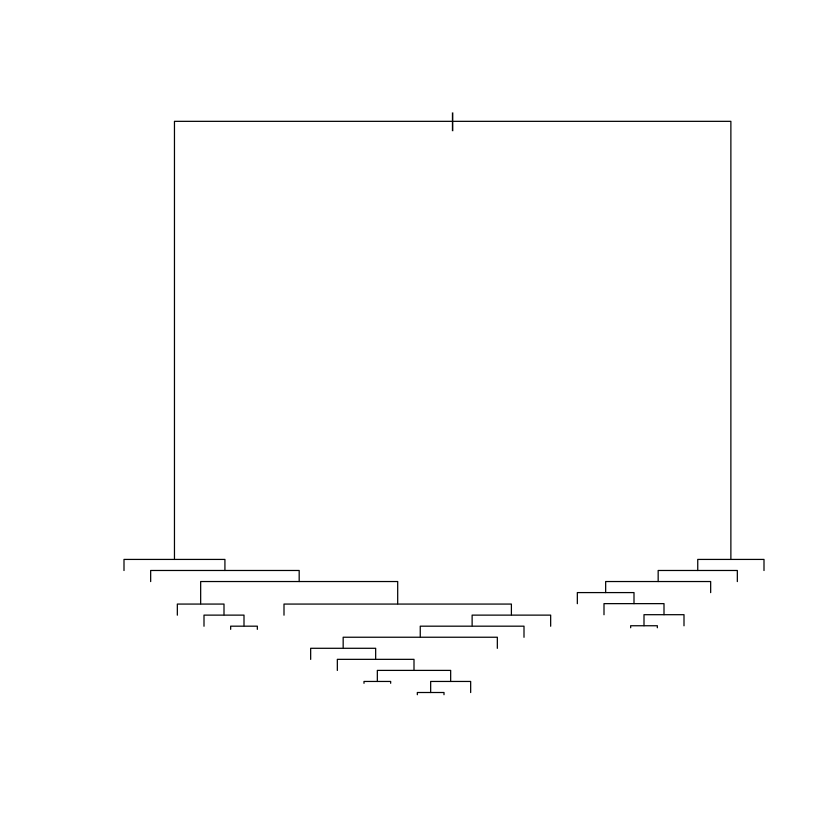

In [132]:
plot(tree_model)

The cross validation accuracy drops off steeply after a single split. We will prune the tree to 5 splits to simplify our model and avoid overfitting.

In [133]:
cv_results <- data.frame(tree_model$cptable)

splits_vs_error <- ggplot(cv_results, aes(nsplit, xerror)) + geom_line(color='darkblue') +
                        xlab('Number of Splits') + ylab('Relative CV Error') 

py$ggplotly(splits_vs_error, session = 'notebook')

In [134]:
# Prune tree to <= 5 splits
pruned_tree <- prune.rpart(tree_model, cp = 0.006)

In [135]:
tree_pred  <- predict(pruned_tree, testing, type = 'class')
confusionMatrix(tree_pred, testing$SeriousDlqin2yrs)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 25436   438
         1  9557  2068
                                             
               Accuracy : 0.7335             
                 95% CI : (0.729, 0.7379)    
    No Information Rate : 0.9332             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2053             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.7269             
            Specificity : 0.8252             
         Pos Pred Value : 0.9831             
         Neg Pred Value : 0.1779             
             Prevalence : 0.9332             
         Detection Rate : 0.6783             
   Detection Prevalence : 0.6900             
      Balanced Accuracy : 0.7761             
                                             
       'Positive' Class : 0                  
    

In the case of predicting loan defaults, false negatives are potentially much more costly than false positives. By applying a weight using the class proportions, we have increased the importance of our response variable and thus decreased the occurrence of false positives to achieve a more balanced model. Our resulting balanced accuracy (AUC) is 0.7761. Which is a respectable first attempt.

> This model only predicts 438 false negatives. 

Unfortunately, this model predicts 9.5k false positives, which would represent people who we rejected loans to, but would have successfully repaid them. This is a loss in profit for the financial institution. Again, incorporating a cost variable would allow more accurate model specification. For example: 1000 defaulted loans may cost less than not offering 10,000 loans to valid customers who would repay us.

Now that we are happy with our model performance, we can examine how the decision tree split the data, as well as the importance of each variable.

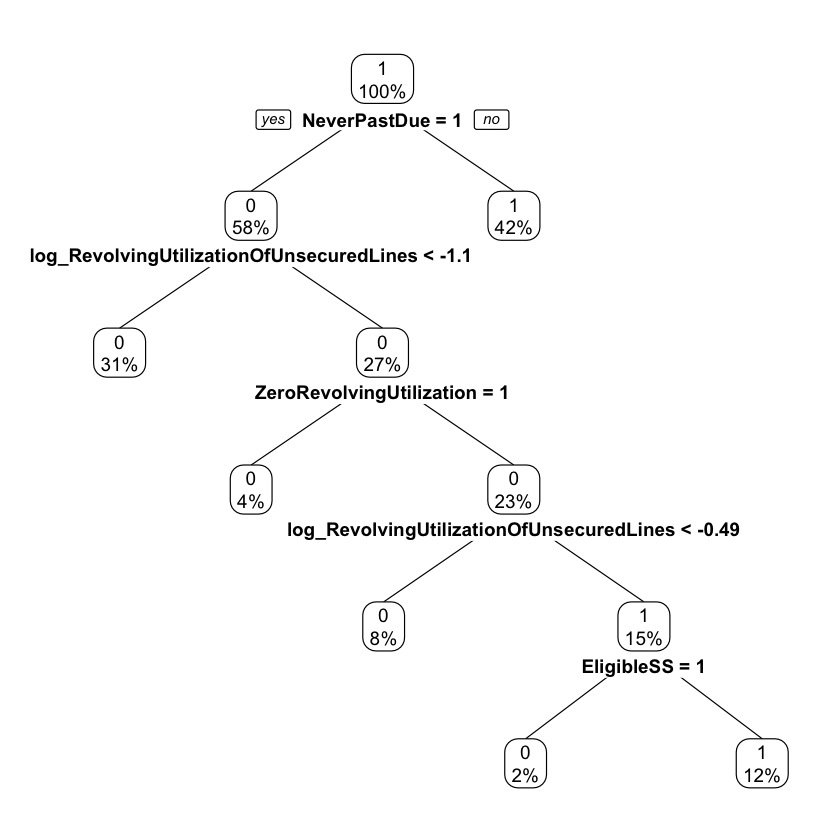

In [136]:
# Plot a pretty Dendrogram
prp(pruned_tree, varlen = 0, clip.right.labs = F, extra = 100, type = 2)

In [137]:
data.frame(pruned_tree$variable.importance)

,pruned_tree.variable.importance
NeverPastDue,29341.77
NumberOfTimesPastDue,28798.69
DelinquenciesPerLine,27949.94
Never30.89DaysPastDueNotWorse,25661.19
NumberOfTime30.89DaysPastDueNotWorse,25118.1
MinorDelinquenciesPerLine,24857.61
log_RevolvingUtilizationOfUnsecuredLines,6989.299
ZeroRevolvingUtilization,2260.983
log_age,1148.169
EligibleSS,853.7662


By far, the most important features are the ones indicating late payments. After the first split, if `LogRevolvingUtilizationofCredit` <= .41 the model predicts the customer will not default, which also makes logical sense. Interestingly, in the last split, customers who qualify for SS (age >=60) are more likely to default on a loan. However, the node purity of this feature is not particularly strong.

# In the next notebook

In the next notebook we will use Python's [scikit-learn](http://scikit-learn.org/stable/) to:

1. Test a more complex machine learning algorithm: Random Forests
2. Tune model parameters using grid search and cross-validation.


- The [second notebook] tests more complex algorithms using [Plotly](https://plot.ly) and Python.

In [138]:
# Save our work to file
write.csv(dt_scaled, 'processed_data.csv', row.names = F)

In [ ]:
from IPython.display import HTML, display

display(HTML('<link href="//fonts.googleapis.com/css?family=Open+Sans:600,400,300,200|Inconsolata|Ubuntu+Mono:400,700" rel="stylesheet" type="text/css" />'))
display(HTML('<link rel="stylesheet" type="text/css" href="https://help.plot.ly/documentation/all_static/css/ipython-notebook-custom.css">'))

import publisher
publisher.publish('credit-risk-analysis', '/python/credit-risk-analysis/', 
                  'Credit Risk Analysis with Plotly', 
                  'Predicting Credit Risk with Python and Plotly')